## 新词挖掘

---

### 介绍

在中文分词领域里，未登录词一直是一大难点，诸如人名、地名、机构名、品牌名、专业名词、缩略语、网络新词等，不可能在词典中实时更新，因此通过分词很可能无法有效区分出这些词。如何自动发现这些新词，是很多领域任务数据预处理过程中的关键步骤，是否能有效地识别新词，将对后续的文本处理产生重要影响。

#### 知识点

- 基于频次的新词挖掘
- 基于自由疑固度以及左右邻字熵的新词挖掘
- 《红楼梦》一书中的新词挖掘实战

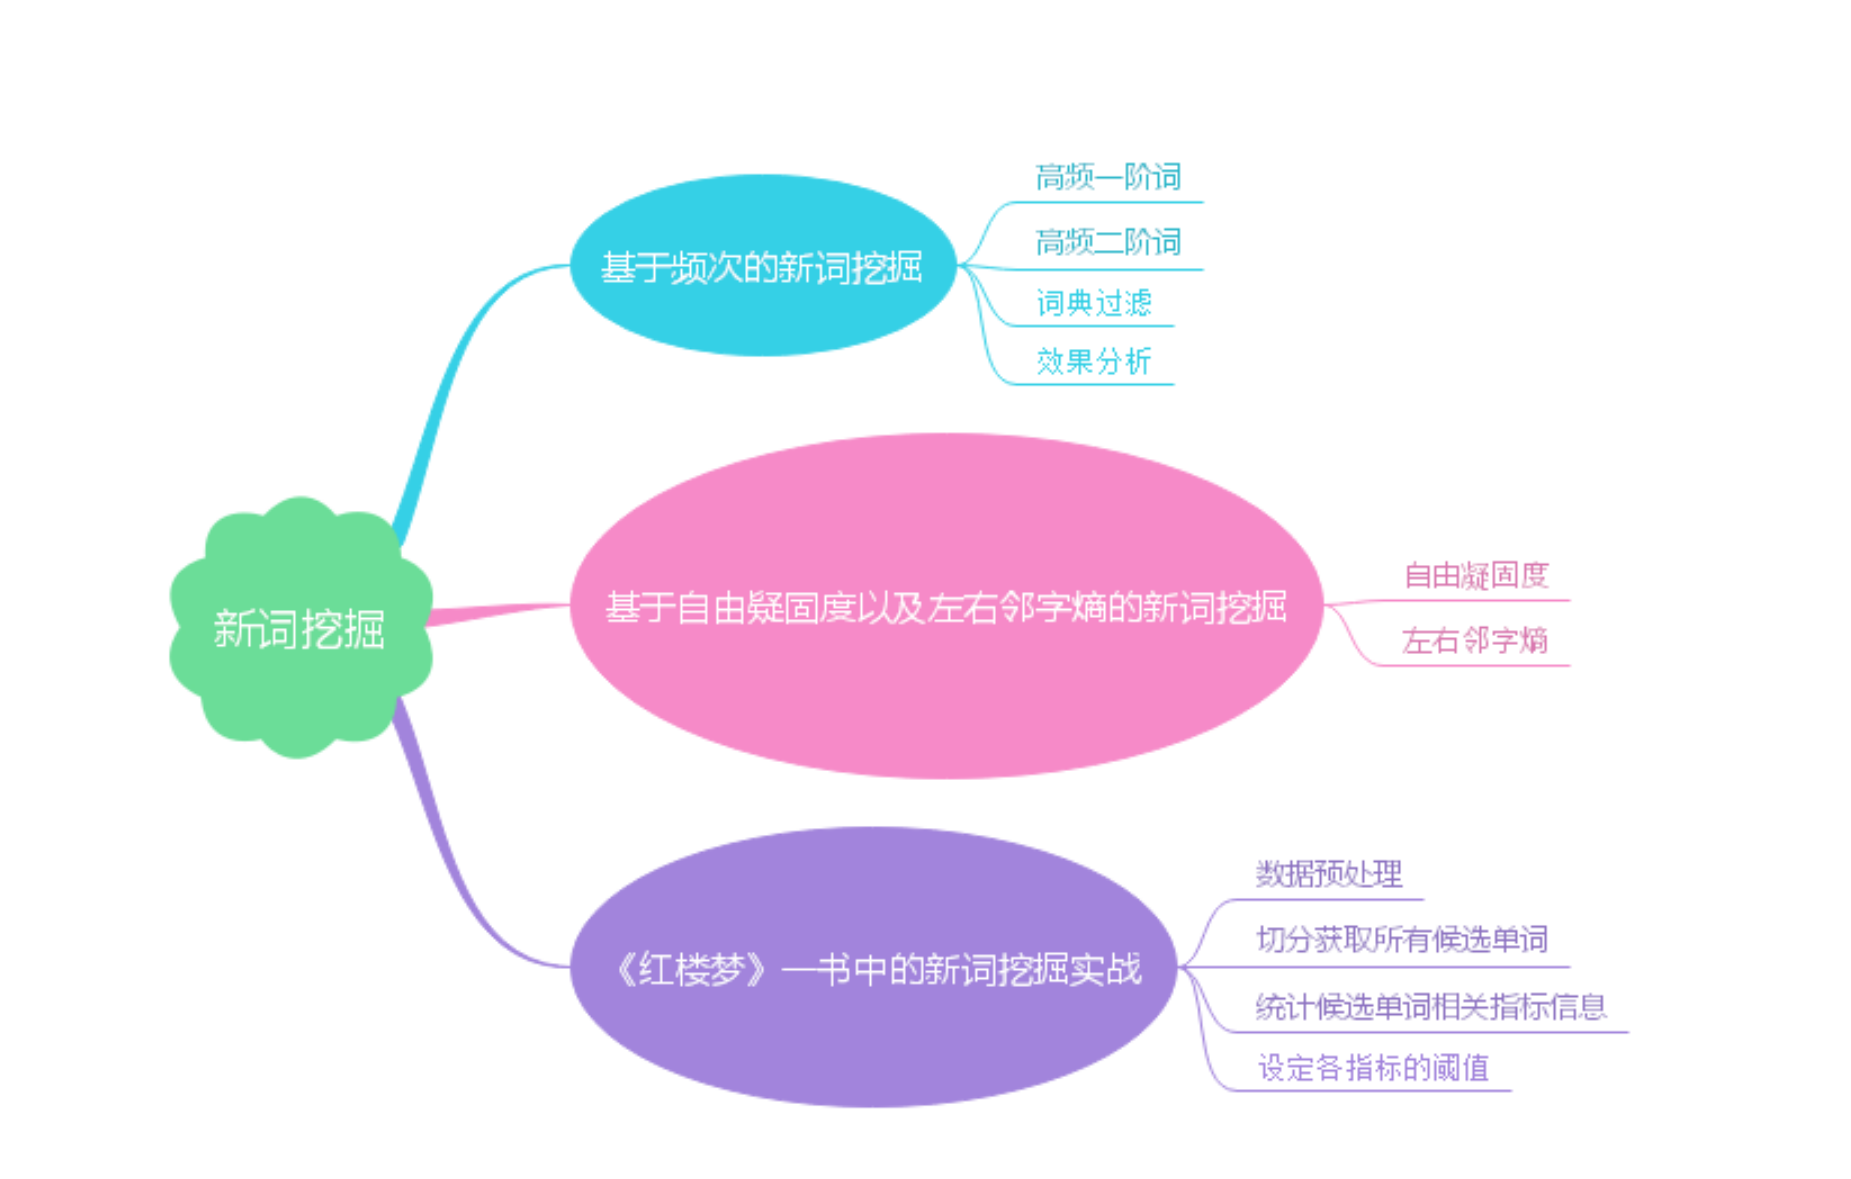

### 基于频次的新词挖掘

怎样的文本片段才算一个新词呢？不难想到的一个方案是，应用分词器对文本进行切分，观察是否存在一些高频的词汇或者词汇组合，并且它们在词典中并未出现过。可以把这些出现频数超过某个阈值的片段或者组合片断提取出来，作为该语料中的新词输出。

例如，对于文本“支持向量机是一类按监督学习方式对数据进行二元分类的广义线性分类器，其决策边界是对学习样本求解的最大边距超平面。铰链损失函数的思想就是让那些未能正确分类的和正确分类的之间的距离要足够的远。支持向量机使用铰链函数计算经验风险并在求解系统中加入了正则化项以优化结构风险，是一个具有稀疏性和稳健性的分类器。”，分词后发现一些在当前词典中没有且高频的词汇及词汇组合，如“支持”+“向量机”、“铰链”，那么“支持向量机”以及“铰链”就可以作为我们新发现的词汇。

这种简单粗暴的方式能否得到可靠的新词呢，下面通过一个实例进行演示。

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 教学代码：</i>

In [ ]:
# 首先对如下语料进行分词
import jieba
text = "支持向量机是一类按监督学习方式对数据进行二元分类的广义线性分类器，其决策边界是对学习样本求解的最大边距超平面。\
支持向量机使用铰链损失函数计算经验风险并在求解系统中加入了正则化项以优化结构风险，是一个具有稀疏性和稳健性的分类器。\
铰链损失函数的思想就是让那些未能正确分类的和正确分类的之间的距离要足够的远。\
支持向量机可以通过核方法进行非线性分类，是常见的核学习方法之一。\
支持向量机被提出于1964年，在二十世纪90年代后得到快速发展并衍生出一系列改进和扩展算法，\
在人像识别、文本分类等模式识别问题中有得到应用。"
words = jieba.lcut(text)

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 动手练习:</i>

获取已有的中文词典：

In [ ]:
def get_chinese_words(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.split()[0] for line in f.readlines()]

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/chinese_words.txt"
CH_DICT = set(get_chinese_words("chinese_words.txt"))

对单词及词组进行频次统计（这里最多的组合词数计算至两阶）:

In [ ]:
import re

unigram_freq, bigram_freq = {}, {}
for i in range(len(words)-1):
    # 一阶计数，即单一单词，为未登录词且由中文构成
    if words[i] not in CH_DICT and not re.search("[^\u4e00-\u9fa5]", words[i]):
        if words[i] in unigram_freq:  # 一阶计数
            unigram_freq[words[i]] += 1
        else:
            unigram_freq[words[i]] = 1
    bigram = words[i]+words[i+1]
    # 二阶计数，即两个单词的组合形式，为未登录词且由中文构成
    if bigram not in CH_DICT and not re.search("[^\u4e00-\u9fa5]", bigram):
        if bigram in bigram_freq:
            bigram_freq[bigram] += 1
        else:
            bigram_freq[bigram] = 1

In [ ]:
unigram_freq_sorted = sorted(
    unigram_freq.items(), key=lambda d: d[1], reverse=True)
bigram_freq_sorted = sorted(
    bigram_freq.items(), key=lambda d: d[1], reverse=True)

获取所有筛选过的一阶、二阶词汇，并且按照词频排序。

In [ ]:
print("unigram:\n", unigram_freq_sorted)
print("bigram:\n", bigram_freq_sorted)

通过以上的计算结果，我们可以发现一些比较靠谱的新词，比如“边距”、“铰链损失”、“损失函数”，但大部分并不算得上是真正的新词。这是因为我们本身应用了工具 jieba 进行分词，而此分词方式又依赖于背后的词库，显然分词结果无法保证对于新词的切分。如果是针对大语料库，在此方法的基础上，还需要大量的人工筛选工作。接下来的内容中，我们来看一种更合理的新词挖掘方式。

### 基于自由疑固度以及左右邻字熵的新词挖掘

除了词频以外，我们还需要考虑以下两大方面作为候选新词的特征：

- 自由疑固度：表示一个字串的凝固程度。
- 左邻字熵与右邻字熵：表示一个字串左右搭配的丰富性。

所谓内部凝固度，用来衡量词搭配是否合理。比如，对于“的教育”、“教育家”这两个搭配，直观上讲“教育家”更为合理，即“教育”和“家”凝固地更紧一些，更像是一个单词。那么在计算机语言学中，如何来衡量这种“直观感受”呢？实际上，PMI（Pointwise Mutual Information，中文称为互信息）被用来度量词汇搭配的紧密度，定义如下（ x，y 表示组成单词的两个成分）：

$$PMI(x,y) = log{\frac{P(x,y)}{P(x)P(y)}}$$

若 PMI 高，即两个词共现的频率远大于两个词自由拼接的乘积概率，则说明这两个词组合在一块并非偶然出现，而是作为一种固定搭配。针对一个词有多种搭配组合，比如“教育家”可以由“教育”+“家”构成，也可以由“教”+“育家”构成，可以取其所有 PMI 中最大值作为内部凝固度。

而除了凝合程度，还需要从整体来看候选新词在语境中的表现。例如“混合”和“混凝”这两个候选新词，两者的内部凝固度都很高。而从左右搭配的丰富程度的角度来看，我们可以说“混合着”、“混合的”、“混合了”、“混合成”等，即在“混合”后面加各种各样的字；但“混凝”的用法却非常固定，除了“混凝土”，基本上后面不能加别的字了。因此可以认为，“混凝”并不单独成词，真正成词的其实是作为整体的“混凝土”。

自由运用程度，便可以一个候选词的左邻字与右邻字的丰富程度，即左右邻字熵来表达，公式如下，$x_i$ 表示候选词 $w$ 左（右）边出现的所有字：

$$Entropy(w) = -\sum_{i}P(x_i)logP(x_i)$$

给频数、内部凝固度与自由运用程度设定一个阈值，再基于词典去除原有的词汇，我们便可以找到新词了。

### 《红楼梦》一书中的新词挖掘实战

在接下来的部分中，我们将基于词频、自由疑固度以及左右邻字熵对《红楼梦》一书进行新词挖掘，主要步骤如下：

- 数据获取及预处理；词典获取。
- 将数据进行切分获取所有切分出的候选单词，并且统计词频信息、候选新词左右出现的字的信息。
- 根据第二步中统计的信息进行 PMI 值以及左右邻字熵的计算。
- 设定各指标的阈值，根据其值获取最终的新词结果。

首先读取数据：

In [ ]:
import re


def preprocess_data(file_path):
    texts = []
    with open(file_path, "r", encoding="utf-8") as f:
        for text in f.readlines():
            text = re.sub("[^\u4e00-\u9fa5。？．，！：]", "",
                          text.strip())  # 只保留中文以及基本的标点符号
            text_splited = re.split("[。？．，！：]", text)  # 按照基本的标点符号进行分块
            texts += text_splited
    texts = [text for text in texts if text is not ""]  # 去除空字符
    return texts

处理数据《红楼梦》一书，按照基本的标点符号进行切分:

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/hongloumeng.txt"
texts = preprocess_data("hongloumeng.txt")
texts

获取已有的中文词典：

In [ ]:
def get_chinese_words(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return [line.split()[0] for line in f.readlines()]

In [ ]:
CH_DICT = set(get_chinese_words("chinese_words.txt"))

接下来需要对文本进行切分以及获取相关的频次信息，这里统一在一个函数 `get_candidate_wordsinfo()` 中，主要逻辑如下：

- 对文本按照一定的长度范围进行切分，切分出所有成词的可能性，这里称之为字符串。
- 对于所有切分出的字符串进行过滤，长度大于等于 2 的词以及不是词典 CH_DICT 中的词作为候选新词。
- 获取所有切分出的字符串的频次信息（在后续计算中需要用到一些字符串的频次信息）、候选新词词频信息、候选新词左右出现的字的统计信息。

In [1]:
def get_candidate_wordsinfo(texts, max_word_len):
    # texts 表示输入的所有文本，max_word_len 表示最长的词长
    # 四个词典均以单词为 key，分别以词频、词频、左字集合、右字集合为 value
    words_freq, candidate_words_freq, candidate_words_left_characters, candidate_words_right_characters = {}, {}, {}, {}
    WORD_NUM = 0  # 统计所有可能的字符串频次
    for text in texts:  # 遍历每个文本
        # word_indexes 中存储了所有可能的词汇的切分下标 (i,j) ，i 表示词汇的起始下标，j 表示结束下标，注意这里有包括了所有的字
        # word_indexes 的生成需要两层循环，第一层循环，遍历所有可能的起始下标 i；第二层循环，在给定 i 的情况下，遍历所有可能的结束下标 j
        word_indexes = [(i, j) for i in range(len(text))
                        for j in range(i + 1, i + 1 + max_word_len)]
        WORD_NUM += len(word_indexes)
        for index in word_indexes:  # 遍历所有词汇的下标
            word = text[index[0]:index[1]]  # 获取单词
            # 更新所有切分出的字符串的频次信息
            if word in words_freq:
                words_freq[word] += 1
            else:
                words_freq[word] = 1
            if len(word) >= 2 and word not in CH_DICT:  # 长度大于等于 2 的词以及不是词典中的词作为候选新词
                # 更新候选新词词频
                if word in candidate_words_freq:
                    candidate_words_freq[word] += 1
                else:
                    candidate_words_freq[word] = 1
                # 更新候选新词左字集合
                if index[0] != 0:  # 当为文本中首个单词时无左字
                    if word in candidate_words_left_characters:
                        candidate_words_left_characters[word].append(
                            text[index[0]-1])
                    else:
                        candidate_words_left_characters[word] = [
                            text[index[0]-1]]
                # 更新候选新词右字集合
                if index[1] < len(text)-1:  # 当为文本中末个单词时无右字
                    if word in candidate_words_right_characters:
                        candidate_words_right_characters[word].append(
                            text[index[1]+1])
                    else:
                        candidate_words_right_characters[word] = [
                            text[index[1]+1]]
    return WORD_NUM, words_freq, candidate_words_freq, candidate_words_left_characters, candidate_words_right_characters

In [2]:
WORD_NUM, words_freq, candidate_words_freq, candidate_words_left_characters, candidate_words_right_characters = \
    get_candidate_wordsinfo(texts=texts, max_word_len=3)  # 字符串最长为 3

NameError: name 'texts' is not defined

在下一步中，计算 PMI 值以及左右邻字熵:

In [3]:
import math


# 计算候选单词的 PMI 值
def compute_pmi(words_freq, candidate_words):
    words_pmi = {}
    for word in candidate_words:
        # 首先，将某个候选单词按照不同的切分位置切分成两项，比如“电影院”可切分为“电”和“影院”以及“电影”和“院”
        bi_grams = [(word[0:i], word[i:]) for i in range(1, len(word))]
        # 对所有切分情况计算 PMI 值，取最大值作为当前候选词的最终 PMI 值
        # words_freq[bi_gram[0]]，words_freq[bi_gram[1]] 分别表示一个候选儿童村新词的前后两部分的出现频次
        words_pmi[word] = max(map(lambda bi_gram: math.log(
            words_freq[word]/(words_freq[bi_gram[0]]*words_freq[bi_gram[1]]/WORD_NUM)), bi_grams))
        """
        通俗版本
        pmis = []
        for bi_gram in bigrams: # 遍历所有切分情况
            pmis.append(math.log(words_freq[word]/(words_freq[bi_gram[0]]*words_freq[bi_gram[1]]/WORD_NUM))) # 计算 pmi 值
        words_pmi[word] = max(pmis) # 取最大值
        """
    return words_pmi

In [ ]:
words_pmi = compute_pmi(words_freq, candidate_words_freq)
words_pmi

计算候选单词的邻字熵:

In [7]:
from collections import Counter


def compute_entropy(candidate_words_characters):
    words_entropy = {}
    for word, characters in candidate_words_characters.items():
        character_freq = Counter(characters)  # 统计邻字的出现分布
        # 根据出现分布计算邻字熵
        words_entropy[word] = sum(map(
            lambda x: - x/len(characters) * math.log(x/len(characters)), character_freq.values()))
    return words_entropy

In [ ]:
words_left_entropy = compute_entropy(candidate_words_left_characters)
words_right_entropy = compute_entropy(candidate_words_right_characters)

最后，根据各指标阈值获取最终的新词结果:

In [8]:
def get_newwords(candidate_words_freq, words_pmi, words_left_entropy, words_right_entropy,
                 words_freq_limit=15, pmi_limit=6, entropy_limit=1):
    # 在每一项指标中根据阈值进行筛选
    candidate_words = [
        k for k, v in candidate_words_freq.items() if v >= words_freq_limit]
    candidate_words_pmi = [k for k, v in words_pmi.items() if v >= pmi_limit]
    candidate_words_left_entropy = [
        k for k, v in words_left_entropy.items() if v >= entropy_limit]
    candidate_words_right_entropy = [
        k for k, v in words_right_entropy.items() if v >= entropy_limit]
    # 对筛选结果进行合并
    return list(set(candidate_words).intersection(candidate_words_pmi, candidate_words_left_entropy, candidate_words_right_entropy))

In [ ]:
get_newwords(candidate_words_freq, words_pmi,
             words_left_entropy, words_right_entropy)

调节阈值:

In [ ]:
get_newwords(candidate_words_freq, words_pmi, words_left_entropy,
             words_right_entropy, words_freq_limit=100, pmi_limit=3, entropy_limit=3)

从以上结果可看出，基于自由疑固度以及左右邻字熵的新词挖掘相较于单纯的基于频次的方法，效果较好些，比如能够将一些人名“黛玉”、“麝月”、“李纨”等识别出，但还是存在一些非单词，例如“ 不过是”、“的丫头”、“宝玉的”、“了宝玉”，“了一个”等，大家可以观察这些“词汇”，思考如何解决此问题（提示：stopword，词性）。

### 实验总结

统计是文本分析的有效手段，比如，挖掘文本主题，舆情分析，挖掘热点事件，或者根据语言习惯进行用户画像等。在本实验中，我们基于一些数据统计方法进行新词挖掘，主要包括以下知识点：

- 基于频次的新词挖掘
- 基于自由疑固度以及左右邻字熵的新词挖掘
- 《红楼梦》一书中的新词挖掘实战

到目前为止，我们所接触的关于词汇的分析方法均为“离散式的分析”，什么意思呢？也就是把词汇当作一个个独立的个体或者说类别来看待，那么，有没有一种方法可以从数学的角度对词汇进行定量的关系分析呢？这就涉及到了下一实验我们将要学习的内容，如何将词汇进行分布式表征，也就是转换成稠密向量的形式，进而基于向量计算来表征词汇间的关系。

<hr><div style="color: #999; font-size: 12px;"><i class="fa fa-copyright" aria-hidden="true"> 本课程内容版权归蓝桥云课所有，禁止转载、下载及非法传播。</i></div>